<a href="https://colab.research.google.com/github/netphoenix/ds_belhard/blob/main/hw4/ds_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа №4 «Data Science начальный уровень»

**Author**: Скробат Александр (tg @FlamePhnx)

Реализовать минимум 5 классификаторов, сравнить метрики между собой, выбрать лучший для Вашего датасета.
Классификаторы:
* Классификатор градиентного бустинга.
* Классификатор CatBoost.
* Классификатор Ada Boost.
* Классификатор Extra Trees.
* Квадратичный дискриминантный анализ.
* Light Gradient Boosting Machine.
* Классификатор K Neighbors.
* Классификатор дерева решений.
* Экстремальный градиентный бустинг.
* Фиктивный классификатор.  
* SVM - линейное ядро.

Обучите модель на наборе данных Credit Card Fraud Detection для предсказания мошеннических транзакций. Проведите гиперпараметрическую настройку и оцените результаты.

In [64]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

# Классификатор CatBoost.
!pip install catboost

# Модели
from sklearn.linear_model import LogisticRegression # Для сравнения
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
# import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Метрики и утилиты
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score, # AUPRC - ключевая метрика
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Борьба с дисбалансом
from imblearn.over_sampling import SMOTE

# Глобальные настройки визуализаций
sns.set_theme(
    style="whitegrid",       # стиль: сетка на белом фоне
    context="paper",         # размер элементов (можно: paper, talk, poster, notebook)
    palette="pastel"         # базовая цветовая палитра --viridis
)

plt.rcParams["figure.figsize"] = (4, 3)   # дефолтный размер графиков
plt.rcParams["axes.titlesize"] = 12       # размер заголовков
plt.rcParams["axes.labelsize"] = 10       # размер подписей осей
plt.rcParams["xtick.labelsize"] = 8       # размер подписей по X
plt.rcParams["ytick.labelsize"] = 8       # размер подписей по Y

# Глобальные настройки форматирования
pd.set_option('display.max_colwidth', 100)
# Снимаем ограничение на ширину вывода (чтобы не было переноса \)
pd.set_option('display.width', None)
# Снимаем ограничение на количество отображаемых столбцов (чтобы не было многоточия ...)
pd.set_option('display.max_columns', None)

In [4]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
# Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
# В этом наборе данных представлены транзакции, которые произошли за два дня, 492 мошенничества из 284 807 транзакций. Датасет сильно разбалансирован, на позитивный класс (фроды) приходится 0,172% всех транзакций.
# Cодержит только числовые переменные, которые являются результатом преобразования PCA (Principal Component Analysis, метод главных компонент).
# Признаки V1, V2, ... V28 являются основными компонентами, полученными с помощью PCA, единственными признаками, которые не были преобразованы, являются 'Time' и 'Amount'.
# Признак 'Time' содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.
# Признак 'Amount' - это сумма транзакции, может быть использована, например, для обучения, зависящего от стоимости.
# Признак 'Class' является принимает значение 1 в случае мошенничества и 0 в противном случае.
# Учитывая коэффициент дисбаланса классов, рекомендуется измерять точность с помощью метрики Площадь под кривой Precision-Recall (AUPRC).
# Она хорошо отражает соотношение между точностью (precision) и полнотой (recall), важными при работе с неравномерным распределением классов.

import kagglehub
import subprocess

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
# !ls {path}

# Выполняем команду ls и получаем список файлов в path
result = subprocess.run(['ls', path], stdout=subprocess.PIPE, text=True)
# Вывод результата в переменную в виде строки
files_list = result.stdout.strip()
print("Файлы в папке:", files_list)
file_path = f"{path}/{files_list}"
print(file_path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud
Файлы в папке: creditcard.csv
/kaggle/input/creditcardfraud/creditcard.csv


In [26]:
full_df = pd.read_csv(file_path)
print("Credit Card Fraud Detection data -  rows:",full_df.shape[0]," columns:", full_df.shape[1])

# Уменьшим датасет, ну уж совсем большой, colab еле ворочается

# Разделяем датасет на мошеннические и нормальные транзакции
fraud_df = full_df[full_df['Class'] == 1]
normal_df = full_df[full_df['Class'] == 0]

# Определяем размер выборки для нормальных транзакций
# Возьмем в 10 раз больше нормальных транзакций, чем мошеннических.
# Это сохранит сильный дисбаланс, но сделает датасет управляемым.
sample_size = len(fraud_df) * 10

# Берем случайную выборку из нормальных транзакций
normal_sample_df = normal_df.sample(n=sample_size, random_state=42)

# Объединяем все мошеннические транзакции с выборкой нормальных
df_small = pd.concat([fraud_df, normal_sample_df])

# Перемешиваем итоговый датасет
data_df = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n--- Датасет был уменьшен ---")
print(f"Размер нового (уменьшенного) датасета: {data_df.shape}")
print("Распределение классов в новом датасете:")
print(data_df['Class'].value_counts())
print(f"Доля мошеннических транзакций: {data_df['Class'].mean():.2%}")

Credit Card Fraud Detection data -  rows: 284807  columns: 31

--- Датасет был уменьшен ---
Размер нового (уменьшенного) датасета: (5412, 31)
Распределение классов в новом датасете:
Class
0    4920
1     492
Name: count, dtype: int64
Доля мошеннических транзакций: 9.09%


In [27]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,91554.0000,-5.1003,3.6334,-3.8439,0.1832,-1.1840,1.6021,-3.0060,-8.6450,1.2855,-3.7175,3.7192,-5.0340,0.9190,-4.2204,-1.0505,-1.6910,-2.3724,0.4501,0.4078,-2.8063,8.2804,-2.7971,1.0907,-0.1593,0.5322,-0.4971,0.9436,0.5536,261.2200,1
1,4855.0000,-0.8598,1.0323,1.9620,1.0788,0.5423,-0.3858,0.4705,-0.1426,0.5929,-0.5831,0.1050,-2.8447,1.6352,1.6749,0.5684,0.0356,0.3609,0.2663,0.5992,-0.0522,-0.4486,-1.1243,-0.2023,-0.2303,0.1177,-0.5959,-0.0290,0.0533,21.0500,0
2,66400.0000,-0.8854,1.3780,1.7268,0.7637,-0.2720,-0.2336,0.3634,0.3698,-0.9646,-0.7004,-0.6931,0.4904,1.2925,0.2490,1.2646,0.1716,-0.2715,0.0973,0.6427,0.0773,-0.0896,-0.4089,-0.1175,0.0211,0.2437,-0.4699,-0.0316,0.0282,29.9900,0
3,123858.0000,2.2645,-0.6252,-2.5757,-1.0168,0.1962,-1.4481,0.2891,-0.4562,-1.0250,1.1601,0.3393,-1.0421,-1.8715,0.9626,-1.0226,0.4475,0.2633,-0.9296,1.1945,-0.1476,0.4887,1.3676,-0.2760,-0.3500,0.7248,0.3098,-0.1126,-0.1094,20.0000,0
4,61011.0000,1.0789,-0.4264,-0.7138,-0.9639,-0.2250,-1.1579,0.5041,-0.2698,0.6365,-0.7308,1.1250,0.7115,-0.9135,0.9970,0.7528,-0.5325,-0.3809,0.4719,1.0225,0.0992,0.1115,0.0972,-0.3402,0.0281,0.8760,-0.4619,-0.0259,0.0143,129.9400,0


In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412 entries, 0 to 5411
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5412 non-null   float64
 1   V1      5412 non-null   float64
 2   V2      5412 non-null   float64
 3   V3      5412 non-null   float64
 4   V4      5412 non-null   float64
 5   V5      5412 non-null   float64
 6   V6      5412 non-null   float64
 7   V7      5412 non-null   float64
 8   V8      5412 non-null   float64
 9   V9      5412 non-null   float64
 10  V10     5412 non-null   float64
 11  V11     5412 non-null   float64
 12  V12     5412 non-null   float64
 13  V13     5412 non-null   float64
 14  V14     5412 non-null   float64
 15  V15     5412 non-null   float64
 16  V16     5412 non-null   float64
 17  V17     5412 non-null   float64
 18  V18     5412 non-null   float64
 19  V19     5412 non-null   float64
 20  V20     5412 non-null   float64
 21  V21     5412 non-null   float64
 22  

In [29]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000,5412.0000
mean,93683.5394,-0.4345,0.3307,-0.6547,0.4198,-0.2506,-0.1283,-0.4954,0.0466,-0.2296,-0.4962,0.3498,-0.5479,-0.0052,-0.6449,0.0003,-0.3718,-0.5786,-0.2083,0.0855,0.0342,0.0633,0.0153,-0.0040,-0.0094,-0.0007,0.0008,0.0159,0.0057,88.4876,0.0909
std,47509.9503,3.0747,2.2643,3.2483,2.0615,2.2559,1.4514,2.9089,2.3065,1.4900,2.4213,1.6616,2.4543,0.9922,2.5452,0.9314,1.8443,2.9381,1.3382,0.9167,0.8369,1.3595,0.8115,0.6946,0.6029,0.5500,0.4827,0.5697,0.3883,226.6559,0.2875
min,23.0000,-30.5524,-29.3360,-31.1037,-4.7902,-22.1055,-17.2821,-43.5572,-41.0443,-13.4341,-24.5883,-2.7653,-18.6837,-3.4493,-19.2143,-4.4989,-14.1299,-25.1628,-9.4987,-4.3668,-18.7571,-22.7976,-8.8870,-19.2543,-2.8366,-4.7816,-1.2827,-7.2635,-8.3080,0.0000,0.0000
25%,53207.7500,-1.0990,-0.5328,-1.2045,-0.7681,-0.7843,-0.8544,-0.6957,-0.2129,-0.7966,-0.6769,-0.6864,-0.6280,-0.6537,-0.6365,-0.5831,-0.6200,-0.5830,-0.5977,-0.4307,-0.2113,-0.2153,-0.5261,-0.1749,-0.3650,-0.3247,-0.3288,-0.0696,-0.0524,4.4900,0.0000
50%,84553.0000,-0.1311,0.1558,0.0061,0.1441,-0.0718,-0.3221,-0.0196,0.0414,-0.1087,-0.1533,0.1081,0.0572,-0.0019,-0.0153,0.0404,-0.0200,-0.0972,-0.0335,0.0528,-0.0514,-0.0045,0.0257,-0.0184,0.0326,0.0244,-0.0494,0.0078,0.0133,20.9800,0.0000
75%,138101.0000,1.2689,0.9739,0.9273,1.0659,0.6293,0.3380,0.5613,0.3830,0.5340,0.3752,0.9592,0.5890,0.6505,0.4454,0.6587,0.4949,0.4018,0.4657,0.5458,0.1748,0.2312,0.5406,0.1520,0.4265,0.3557,0.2447,0.1238,0.0934,78.0425,0.0000
max,172703.0000,2.3700,22.0577,3.7702,12.1147,28.5165,10.1537,15.9158,20.0072,6.9496,11.1657,12.0189,3.1617,3.5303,5.2098,3.8814,3.8019,6.7394,3.7903,5.2283,13.1198,27.2028,8.3620,13.7501,2.9716,2.7446,2.8592,4.6109,15.3732,5627.0600,1.0000


In [30]:
# Проверим, есть ли пропущенные данные

total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Percent,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Количество объектов в каждом классе:
Class
0    4920
1     492
Name: count, dtype: int64

Доля мошеннических транзакций: 9.0909%


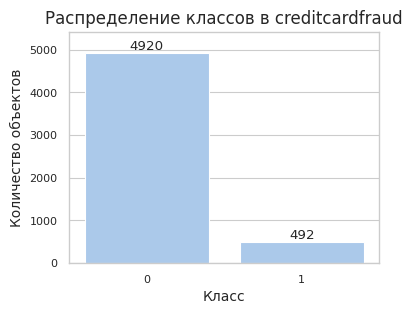

In [31]:
# Проверим дисбаланс данных в отношении целевого значения

# Подсчёт количества объектов в 'Class'
class_counts = data_df['Class'].value_counts()

print("Количество объектов в каждом классе:")
print(class_counts)

# Доля мошеннических транзакций
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nДоля мошеннических транзакций: {fraud_percentage:.4f}%")

# Построение графика с подписью количества над столбцами
# ax = sns.countplot(x='Class', data=data_df, palette=['#3498db', '#e74c3c'])
ax = sns.countplot(x='Class', data=data_df)

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.title('Распределение классов в creditcardfraud')
plt.xlabel('Класс')
plt.ylabel('Количество объектов')
plt.ylim(0, class_counts.max() * 1.1)  # небольшой отступ сверху для подписей
plt.show()


In [32]:
# Для следующих моделей масштабирование обязательно или сильно рекомендуется:
# SVM (особенно с линейным ядром) — чувствителен к масштабу данных
# KNeighborsClassifier (KNN) — зависит от расстояний между точками, масштабирование обязательно
# Логистическая регрессия (LogisticRegression) — требует стандартизации
# QDA (Quadratic Discriminant Analysis) — для корректной оценки ковариационных матриц предпочтительно масштабирование

# Масштабирование признаков 'Amount' и 'Time' с использованием StandardScaler
scaler = StandardScaler()

data_df['scaled_amount'] = scaler.fit_transform(data_df['Amount'].values.reshape(-1, 1))
data_df['scaled_time'] = scaler.fit_transform(data_df['Time'].values.reshape(-1, 1))

# Удаляем оригинальные столбцы
data_df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Теперь data_df содержит скалированные признаки Time_scaled и Amount_scaled
data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-5.1003,3.6334,-3.8439,0.1832,-1.1840,1.6021,-3.0060,-8.6450,1.2855,-3.7175,3.7192,-5.0340,0.9190,-4.2204,-1.0505,-1.6910,-2.3724,0.4501,0.4078,-2.8063,8.2804,-2.7971,1.0907,-0.1593,0.5322,-0.4971,0.9436,0.5536,1,0.7622,-0.0448
1,-0.8598,1.0323,1.9620,1.0788,0.5423,-0.3858,0.4705,-0.1426,0.5929,-0.5831,0.1050,-2.8447,1.6352,1.6749,0.5684,0.0356,0.3609,0.2663,0.5992,-0.0522,-0.4486,-1.1243,-0.2023,-0.2303,0.1177,-0.5959,-0.0290,0.0533,0,-0.2976,-1.8699
2,-0.8854,1.3780,1.7268,0.7637,-0.2720,-0.2336,0.3634,0.3698,-0.9646,-0.7004,-0.6931,0.4904,1.2925,0.2490,1.2646,0.1716,-0.2715,0.0973,0.6427,0.0773,-0.0896,-0.4089,-0.1175,0.0211,0.2437,-0.4699,-0.0316,0.0282,0,-0.2581,-0.5743
3,2.2645,-0.6252,-2.5757,-1.0168,0.1962,-1.4481,0.2891,-0.4562,-1.0250,1.1601,0.3393,-1.0421,-1.8715,0.9626,-1.0226,0.4475,0.2633,-0.9296,1.1945,-0.1476,0.4887,1.3676,-0.2760,-0.3500,0.7248,0.3098,-0.1126,-0.1094,0,-0.3022,0.6352
4,1.0789,-0.4264,-0.7138,-0.9639,-0.2250,-1.1579,0.5041,-0.2698,0.6365,-0.7308,1.1250,0.7115,-0.9135,0.9970,0.7528,-0.5325,-0.3809,0.4719,1.0225,0.0992,0.1115,0.0972,-0.3402,0.0281,0.8760,-0.4619,-0.0259,0.0143,0,0.1829,-0.6878


In [33]:
# Определение признаков и целевой переменной
X = data_df.drop('Class', axis=1)
y = data_df['Class']

# Разделение на обучающую и тестовую выборки
# Используем stratify=y, чтобы сохранить пропорцию классов в обеих выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (4329, 30)
Размер тестовой выборки: (1083, 30)


In [35]:
# scale_pos_weight: для XGBoost, LightGBM. Отношение числа отрицательных примеров к числу положительных

# Расчет веса для положительного класса
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Scale_pos_weight: {scale_pos_weight_value:.2f}")

# Словарь с классификаторами

# classifiers = {
#     "Фиктивный (Dummy)": DummyClassifier(strategy='most_frequent'),
#     "SVM - линейное ядро": LinearSVC(dual=False, class_weight='balanced', random_state=42, max_iter=2000),
#     "K-Neighbors (KNN)": KNeighborsClassifier(n_jobs=-1),  # поддерживает многопоточность
#     "Дерево решений": DecisionTreeClassifier(class_weight='balanced', random_state=42),
#     "AdaBoost": AdaBoostClassifier(random_state=42),
#     # "Градиентный бустинг": GradientBoostingClassifier(random_state=42),
#     "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
#     "Квадр. дискрим. анализ (QDA)": QuadraticDiscriminantAnalysis(),
#     "XGBoost": xgb.XGBClassifier(
#         objective='binary:logistic',
#         scale_pos_weight=scale_pos_weight_value,
#         eval_metric='logloss',
#         random_state=42,
#         tree_method='hist',
#         device='cuda',        # Указание устройств CUDA для GPU
#         n_jobs=-1
#     ),
#     "LightGBM": lgb.LGBMClassifier(
#         objective='binary',
#         scale_pos_weight=scale_pos_weight_value,
#         random_state=42,
#         device='gpu',
#         n_jobs=-1
#     ),
#     "CatBoost": cb.CatBoostClassifier(
#         auto_class_weights='Balanced',
#         verbose=0,
#         random_state=42,
#         task_type='GPU',
#         thread_count=-1  # в CatBoost для многопоточности используется thread_count
#     )
# }

classifiers = {
    "Фиктивный (Dummy)": DummyClassifier(strategy='most_frequent'),
    "SVM - линейное ядро": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    # "SVM - линейное ядро": LinearSVC(dual=False, class_weight='balanced', random_state=42, max_iter=2000),
    "K-Neighbors (KNN)": KNeighborsClassifier(),
    "Дерево решений": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Градиентный бустинг": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=42),
    "Квадр. дискрим. анализ (QDA)": QuadraticDiscriminantAnalysis(),
    "XGBoost": XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight_value, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42, verbose=-1),
    "CatBoost": cb.CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
}

# Обучение и оценка моделей
results = []
for name, clf in classifiers.items():
    print(f"Оцениваем модель: {name}...")
    start_time = time()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else [0.5] * len(y_test)

    end_time = time()

    results.append({
        "Модель": name,
        "AU PRC": average_precision_score(y_test, y_proba), # Area Under PR Curve
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "Precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1-score": f1_score(y_test, y_pred, pos_label=1),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Время (сек)": round(end_time - start_time, 2)
    })

# Преобразование результатов в DataFrame для удобного просмотра
results_df = pd.DataFrame(results).sort_values(by='AU PRC', ascending=False).reset_index(drop=True)

# Устанавливаем формат вывода для лучшей читаемости
pd.options.display.float_format = '{:.4f}'.format

print("\n--- Итоговая таблица метрик (отсортировано по AU PRC) ---")
print(results_df)

Scale_pos_weight: 9.99
Оцениваем модель: Фиктивный (Dummy)...
Оцениваем модель: SVM - линейное ядро...
Оцениваем модель: K-Neighbors (KNN)...
Оцениваем модель: Дерево решений...
Оцениваем модель: AdaBoost...
Оцениваем модель: Градиентный бустинг...
Оцениваем модель: Extra Trees...
Оцениваем модель: Квадр. дискрим. анализ (QDA)...
Оцениваем модель: XGBoost...
Оцениваем модель: LightGBM...
Оцениваем модель: CatBoost...

--- Итоговая таблица метрик (отсортировано по AU PRC) ---
                          Модель  AU PRC  Recall  Precision  F1-score  \
0                        XGBoost  0.9879  0.8878     0.9775    0.9305   
1                       LightGBM  0.9818  0.8878     1.0000    0.9405   
2                       CatBoost  0.9782  0.8776     0.9663    0.9198   
3                    Extra Trees  0.9709  0.8776     1.0000    0.9348   
4            Градиентный бустинг  0.9706  0.8776     0.9556    0.9149   
5            SVM - линейное ядро  0.9654  0.9490     0.8692    0.9073   
6        

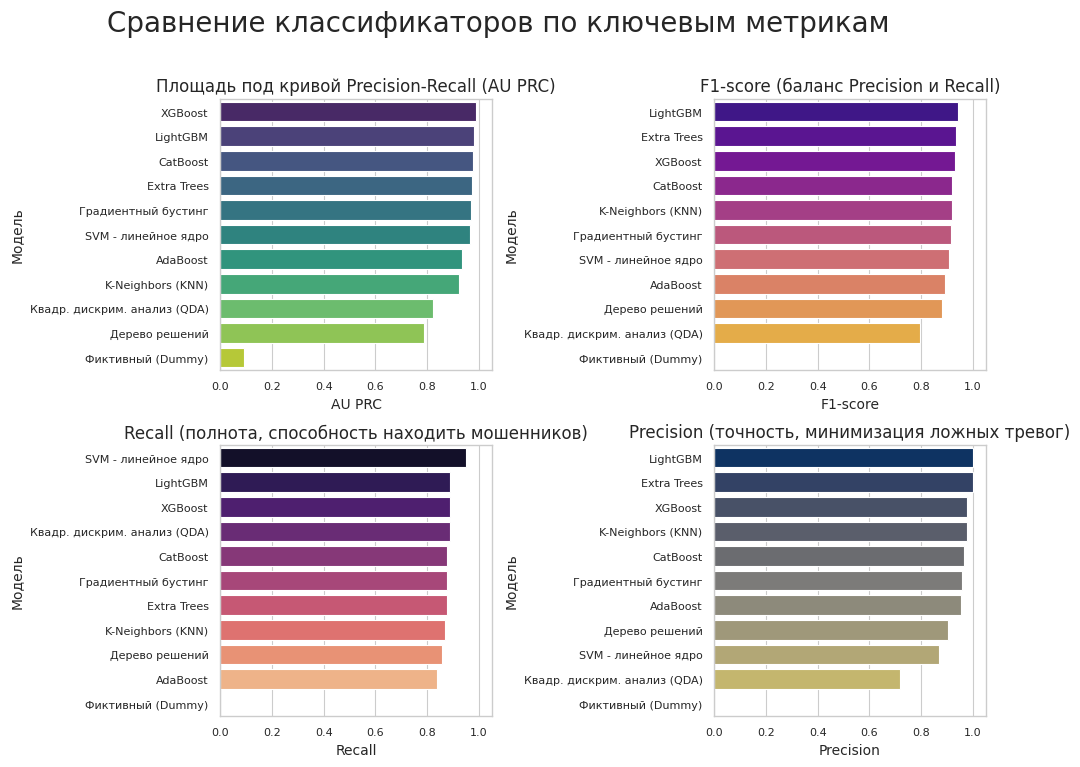

In [61]:
# Устанавливаем стиль и размер графиков
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 8

# Создаем фигуру с 4 подграфиками
fig, axes = plt.subplots(2, 2)
fig.suptitle('Сравнение классификаторов по ключевым метрикам', fontsize=20)

# Сортируем DataFrame для каждого графика для наглядности
# График 1: AU PRC (главная метрика)
df_sorted_auprc = results_df.sort_values(by='AU PRC', ascending=False)
sns.barplot(ax=axes[0, 0], x='AU PRC', y='Модель', data=df_sorted_auprc,
            palette='viridis', hue='Модель', legend=False)
axes[0, 0].set_title('Площадь под кривой Precision-Recall (AU PRC)')
axes[0, 0].set_xlim(0, 1.05)

# График 2: F1-score
df_sorted_f1 = results_df.sort_values(by='F1-score', ascending=False)
sns.barplot(ax=axes[0, 1], x='F1-score', y='Модель', data=df_sorted_f1,
            palette='plasma', hue='Модель', legend=False)
axes[0, 1].set_title('F1-score (баланс Precision и Recall)')
axes[0, 1].set_xlim(0, 1.05)

# График 3: Recall
df_sorted_recall = results_df.sort_values(by='Recall', ascending=False)
sns.barplot(ax=axes[1, 0], x='Recall', y='Модель', data=df_sorted_recall,
            palette='magma', hue='Модель', legend=False)
axes[1, 0].set_title('Recall (полнота, способность находить мошенников)')
axes[1, 0].set_xlim(0, 1.05)

# График 4: Precision
df_sorted_precision = results_df.sort_values(by='Precision', ascending=False)
sns.barplot(ax=axes[1, 1], x='Precision', y='Модель', data=df_sorted_precision,
            palette='cividis', hue='Модель', legend=False)
axes[1, 1].set_title('Precision (точность, минимизация ложных тревог)')
axes[1, 1].set_xlim(0, 1.05)

# Улучшаем компоновку
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [36]:
results_df

,Модель,AU PRC,Recall,Precision,F1-score,ROC AUC,Время (сек)
0,XGBoost,0.9879,0.8878,0.9775,0.9305,0.9986,0.3600
1,LightGBM,0.9818,0.8878,1.0000,0.9405,0.9978,0.3800
2,CatBoost,0.9782,0.8776,0.9663,0.9198,0.9971,6.7300
3,Extra Trees,0.9709,0.8776,1.0000,0.9348,0.9961,0.3200
4,Градиентный бустинг,0.9706,0.8776,0.9556,0.9149,0.9954,5.1300
5,SVM - линейное ядро,0.9654,0.9490,0.8692,0.9073,0.9928,1.7500
6,AdaBoost,0.9361,0.8367,0.9535,0.8913,0.9907,1.0900
7,K-Neighbors (KNN),0.9232,0.8673,0.9770,0.9189,0.9617,0.0500
8,Квадр. дискрим. анализ (QDA),0.8233,0.8878,0.7190,0.7945,0.9777,0.0100
9,Дерево решений,0.7871,0.8571,0.9032,0.8796,0.9240,0.1400


In [39]:
# Применим SMOTE (Synthetic Minority Over-sampling Technique) для генерации синтетических примеров мошеннических транзакций в обучающей выборке.
# Важно: SMOTE применяется только к обучающим данным (X_train, y_train). Тестовая выборка должна оставаться в первозданном виде.

print("Классы до SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Классы после SMOTE:", y_train_resampled.value_counts())

# Повторное обучение на сбалансированных данных
results_list_smote = []

for name, clf in classifiers.items():
    print(f"Обучение {name} на данных SMOTE...")
    start_time = time()

    # Обучаем на сбалансированных данных
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else [0.5] * len(y_test)

    end_time = time()

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results_list_smote.append({
        'Модель': name,
        'AU PRC': average_precision_score(y_test, y_proba),
        'Recall (1)': round(report['1']['recall'], 4),
        'Precision (1)': round(report['1']['precision'], 4),
        'F1-score (1)': round(report['1']['f1-score'], 4),
        'ROC AUC': round(roc_auc_score(y_test, y_proba), 4),
        'Время (сек)': round(end_time - start_time, 2)
    })

results_df_after = pd.DataFrame(results_list_smote).sort_values(by='AU PRC', ascending=False)
print("\n--- Результаты после применения SMOTE ---")
print(results_df_after)

Классы до SMOTE: Class
0    3935
1     394
Name: count, dtype: int64
Классы после SMOTE: Class
0    3935
1    3935
Name: count, dtype: int64
Обучение Фиктивный (Dummy) на данных SMOTE...
Обучение SVM - линейное ядро на данных SMOTE...
Обучение K-Neighbors (KNN) на данных SMOTE...
Обучение Дерево решений на данных SMOTE...
Обучение AdaBoost на данных SMOTE...
Обучение Градиентный бустинг на данных SMOTE...
Обучение Extra Trees на данных SMOTE...
Обучение Квадр. дискрим. анализ (QDA) на данных SMOTE...
Обучение XGBoost на данных SMOTE...
Обучение LightGBM на данных SMOTE...
Обучение CatBoost на данных SMOTE...

--- Результаты после применения SMOTE ---
                          Модель  AU PRC  Recall (1)  Precision (1)  \
9                       LightGBM  0.9785      0.9388         0.9293   
8                        XGBoost  0.9748      0.9388         0.9109   
10                      CatBoost  0.9722      0.8980         0.8980   
6                    Extra Trees  0.9698      0.8878     

In [40]:
results_df_after

,Модель,AU PRC,Recall (1),Precision (1),F1-score (1),ROC AUC,Время (сек)
9,LightGBM,0.9785,0.9388,0.9293,0.9340,0.9966,0.4300
8,XGBoost,0.9748,0.9388,0.9109,0.9246,0.9960,0.4000
10,CatBoost,0.9722,0.8980,0.8980,0.8980,0.9948,7.6500
6,Extra Trees,0.9698,0.8878,0.9886,0.9355,0.9957,0.4700
5,Градиентный бустинг,0.9679,0.8980,0.8627,0.8800,0.9930,9.6400
1,SVM - линейное ядро,0.9620,0.9490,0.8087,0.8732,0.9912,3.6800
4,AdaBoost,0.9592,0.9388,0.7667,0.8440,0.9906,1.9200
2,K-Neighbors (KNN),0.8481,0.9388,0.7132,0.8106,0.9613,0.0800
7,Квадр. дискрим. анализ (QDA),0.8360,0.8980,0.7395,0.8111,0.9756,0.0100
3,Дерево решений,0.6598,0.9388,0.6970,0.8000,0.9491,0.3400


In [52]:
# Выбор кандидата:
# XGBoost - кандидат для настройки. Лидер по главной метрике (AU PRC) без использования SMOTE
# Настройка гиперпараметров для XGBoost. Будем использовать RandomizedSearchCV - это эффективнее, чем полный перебор (GridSearchCV), так как позволяет исследовать более широкое пространство параметров за то же время
# целевой метрикой для оптимизации будет average_precision (AU PRC).

# Рассчитываем scale_pos_weight на основе тренировочной выборки
# X_train, y_train из уменьшенного датасета
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Рассчитанный scale_pos_weight: {scale_pos_weight_value:.2f}")

# настроим ключевые параметры, влияющие на сложность модели, скорость обучения и регуляризацию.
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    # Мы передаем scale_pos_weight напрямую, так как обучаемся на несбалансированных данных
    'scale_pos_weight': [scale_pos_weight_value]
}

# Инициализация модели и RandomizedSearchCV
xgb = XGBClassifier(objective='binary:logistic', eval_metric='aucpr', random_state=42)

# n_iter - количество комбинаций параметров, которые нужно проверить
# cv=3 - 3-кратная кросс-валидация
# scoring='average_precision' - наша главная метрика для оптимизации
# n_jobs=-1 - использовать все доступные ядра CPU для ускорения
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='average_precision',
    cv=5,
    # Устанавливаем verbose=2 для детального вывода
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("--- Начинаем гиперпараметрическую настройку XGBoost ---")
# Обучаем на сбалансированных данных
random_search.fit(X_train, y_train)

# Вывод лучших найденных параметров
print("\n--- Настройка завершена ---")
print(f"Лучший AU PRC на кросс-валидации: {random_search.best_score_:.4f}")
print("Лучшие найденные параметры:")
print(random_search.best_params_)

# Сохраняем лучшую модель
best_xgb_model = random_search.best_estimator_



Рассчитанный scale_pos_weight: 9.99
--- Начинаем гиперпараметрическую настройку XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Настройка завершена ---
Лучший AU PRC на кросс-валидации: 0.9330
Лучшие найденные параметры:
{'subsample': 0.7, 'scale_pos_weight': np.float64(9.98730964467005), 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}



--- Финальный отчет для настроенной модели XGBoost ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       985
           1       0.96      0.90      0.93        98

    accuracy                           0.99      1083
   macro avg       0.97      0.95      0.96      1083
weighted avg       0.99      0.99      0.99      1083

Финальный AU PRC: 0.9819


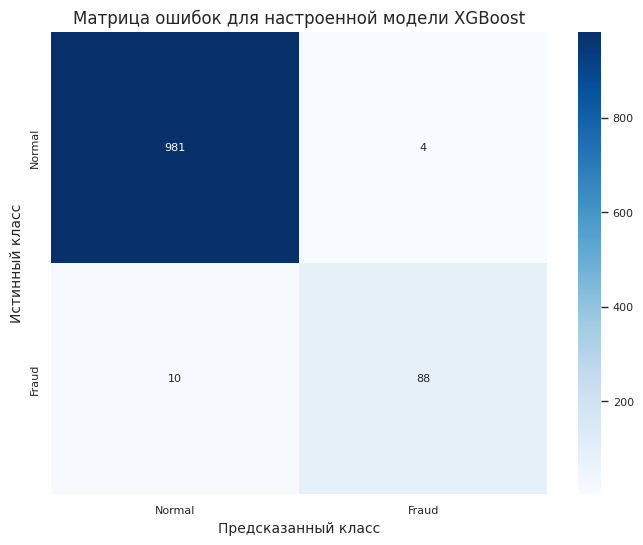

In [59]:
# Предсказания на тестовой выборке
y_pred_tuned = best_xgb_model.predict(X_test)
y_proba_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Финальный отчет для настроенной модели XGBoost ---")
print(classification_report(y_test, y_pred_tuned))

# Рассчитываем ключевые метрики
final_au_prc = average_precision_score(y_test, y_proba_tuned)

print(f"Финальный AU PRC: {final_au_prc:.4f}")

# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок для настроенной модели XGBoost')
plt.show()

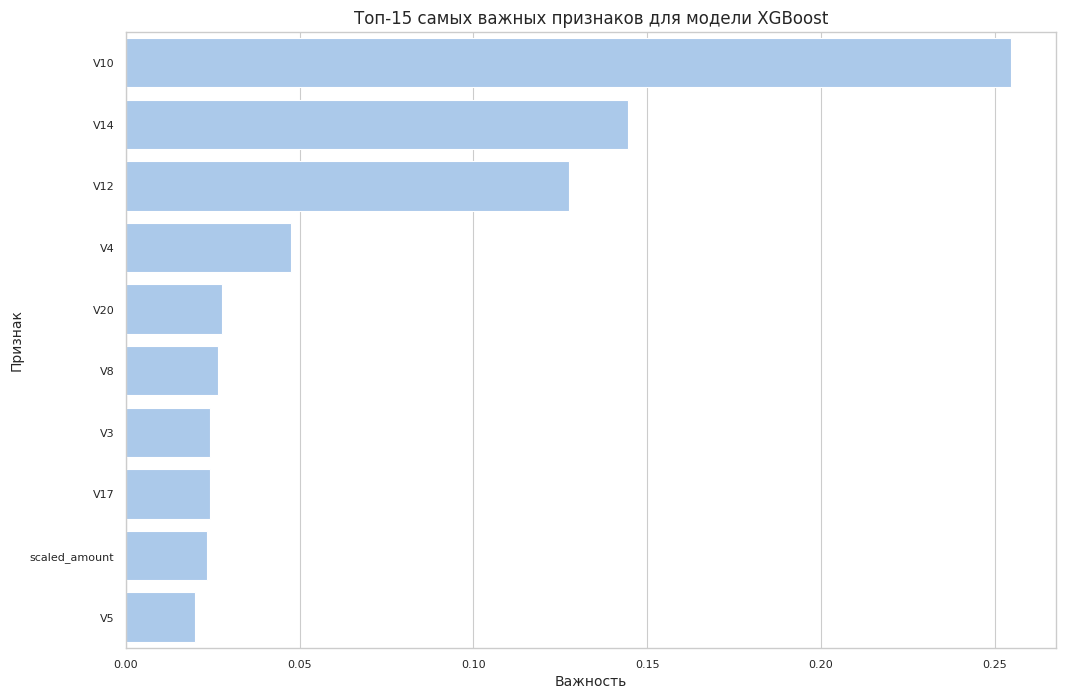

In [72]:
# Создаем DataFrame с важностью признаков
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Визуализируем топ-15 самых важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Топ-15 самых важных признаков для модели XGBoost')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()